# K-Nearest Neighbors (KNN) Model - Unique
###
This section explains the steps involved in building a KNN model specifically tailored to a dataset.# KNN MODEL (UNIQUE)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from itertools import cycle

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('/Users/atharvasapkal/Downloads/preprocessed_thyroid_data.csv')

# Encode the target variable if necessary
label_encoder = LabelEncoder()
data['target'] = label_encoder.fit_transform(data['target'])

# Split features and target
X = data.drop(columns=['target'])
y = data['target']

# Handle missing values (e.g., fill with median values)
X = X.fillna(X.median())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 70% training, 15% testing, and 15% validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Parameter tuning using GridSearchCV
param_grid = {
    'n_neighbors': range(1, 31),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best KNN model
best_knn = grid_search.best_estimator_

# Predict on the test set
y_pred = best_knn.predict(X_test)

In [2]:
# Print results
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}



Validation Set Evaluation:
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.98      1037
           2       0.78      0.74      0.76        42
           3       0.92      0.74      0.82        74

    accuracy                           0.97      1153
   macro avg       0.89      0.82      0.85      1153
weighted avg       0.96      0.97      0.96      1153

Confusion Matrix:
[[1027    7    3]
 [   9   31    2]
 [  17    2   55]]


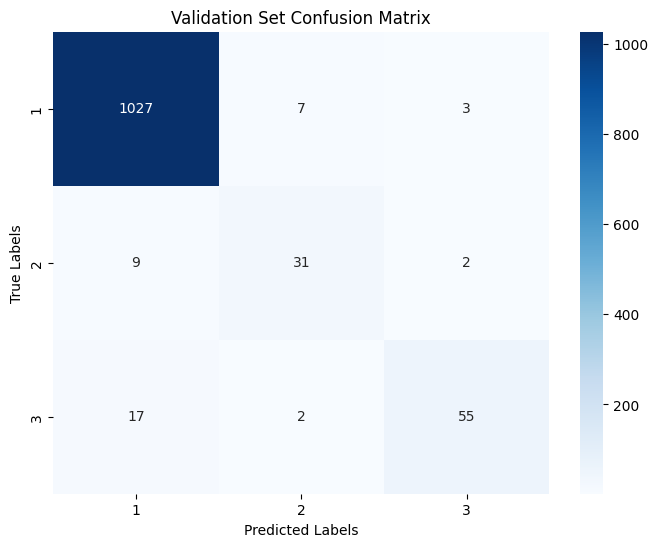

In [3]:
# Predict on the validation set
y_pred_val = best_knn.predict(X_val)

# Convert target names to string format
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_pred_val)
val_report = classification_report(y_val, y_pred_val, target_names=target_names)
val_conf_matrix = confusion_matrix(y_val, y_pred_val)

# Print the results for the validation set
print("\nValidation Set Evaluation:")
print(f"Accuracy: {val_accuracy:.2f}")
print("Classification Report:")
print(val_report)
print("Confusion Matrix:")
print(val_conf_matrix)

# Function to plot a confusion matrix
def plot_confusion_matrix(conf_matrix, title, target_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the validation set confusion matrix
plot_confusion_matrix(val_conf_matrix, "Validation Set Confusion Matrix", target_names)

Test Set Evaluation:
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.99      0.97      1013
           2       0.82      0.64      0.72        58
           3       0.87      0.72      0.78        81

    accuracy                           0.95      1152
   macro avg       0.88      0.78      0.83      1152
weighted avg       0.95      0.95      0.95      1152

Confusion Matrix:
[[999   8   6]
 [ 18  37   3]
 [ 23   0  58]]


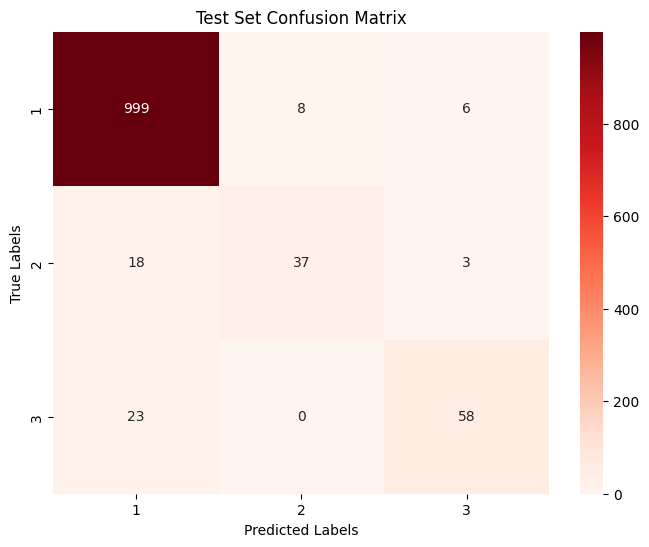

In [4]:
# Predict on the test set
y_pred_test = best_knn.predict(X_test)

# Convert target names to string format
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_report = classification_report(y_test, y_pred_test, target_names=target_names)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print the results for the test set
print("Test Set Evaluation:")
print(f"Accuracy: {test_accuracy:.2f}")
print("Classification Report:")
print(test_report)
print("Confusion Matrix:")
print(test_conf_matrix)

# Function to plot a confusion matrix
def plot_confusion_matrix(conf_matrix, title, target_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the test set confusion matrix
plot_confusion_matrix(test_conf_matrix, "Test Set Confusion Matrix", target_names)

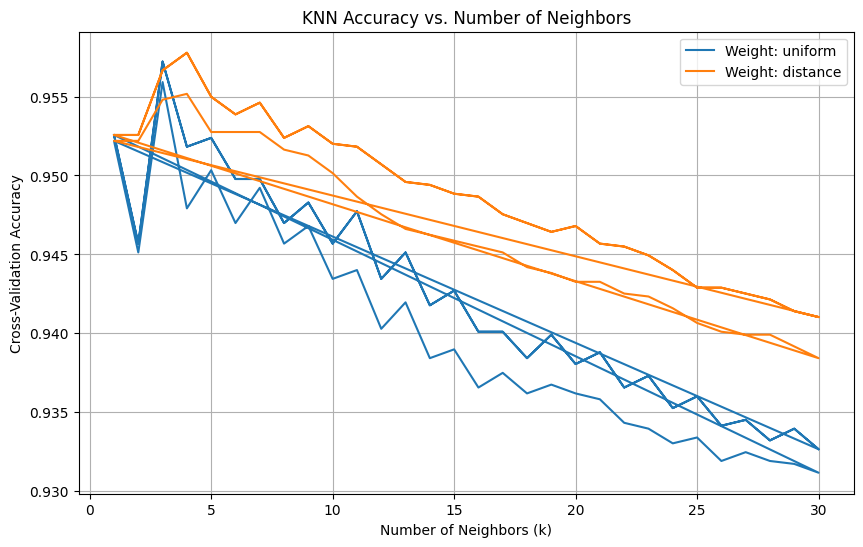

In [5]:
# Visualize accuracy trends during tuning
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
for weight in param_grid['weights']:
    subset = results[results['param_weights'] == weight]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=f'Weight: {weight}')

plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

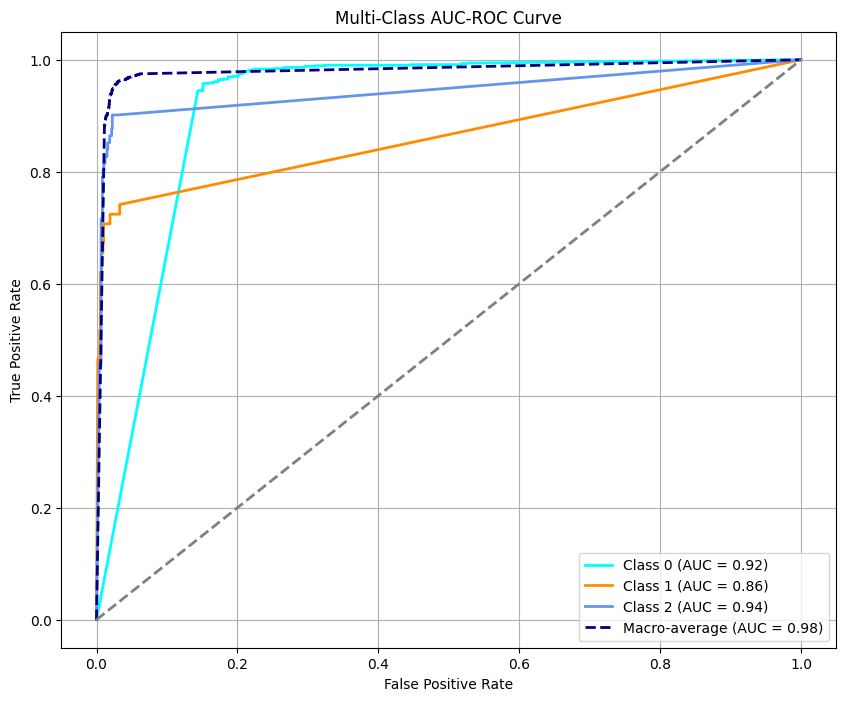

In [6]:
# Multi-Class AUC-ROC Curve
y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
n_classes = y_test_binarized.shape[1]

# Predict probabilities for all classes
y_prob = best_knn.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', lw=2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.title('Multi-Class AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Logistic Regression Model - Common
This section demonstrates the use of Logistic Regression as the baseline model for comparison.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [8]:
# Step 1: Load the preprocessed dataset
file_path = r'/Users/atharvasapkal/Downloads/preprocessed_thyroid_data.csv'
preprocessed_data = pd.read_csv(file_path)

In [9]:
# Step 2: Define features and target
X = preprocessed_data.drop(columns=['target'])  # Features
y = preprocessed_data['target']  # Target variable

In [10]:
# Step 3: Split into 70% training + 30% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Step 4: Split the temporary set into 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Step 5: Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (5376, 10) (5376,)
Validation set shape: (1152, 10) (1152,)
Test set shape: (1153, 10) (1153,)


In [11]:
# Step 6: Train the Logistic Regression model
model = LogisticRegression(multi_class='ovr', max_iter=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Predict on the validation set
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Step 8: Calculate accuracy for validation and test sets
accuracy_val = accuracy_score(y_val, y_val_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Validation Accuracy: 0.9436
Test Accuracy: 0.9324


Validation Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97      1015
           2       0.89      0.36      0.52        47
           3       0.94      0.66      0.77        90

    accuracy                           0.94      1152
   macro avg       0.93      0.67      0.75      1152
weighted avg       0.94      0.94      0.94      1152

Validation Confusion Matrix:
[[1011    2    2]
 [  28   17    2]
 [  31    0   59]]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.99      0.96      1016
           2       0.75      0.38      0.51        47
           3       0.88      0.57      0.69        90

    accuracy                           0.93      1153
   macro avg       0.86      0.65      0.72      1153
weighted avg       0.93      0.93      0.92      1153

Test Confusion Matrix:
[[1006    6    4]
 [  26   18    3]
 [  39    0   51]]


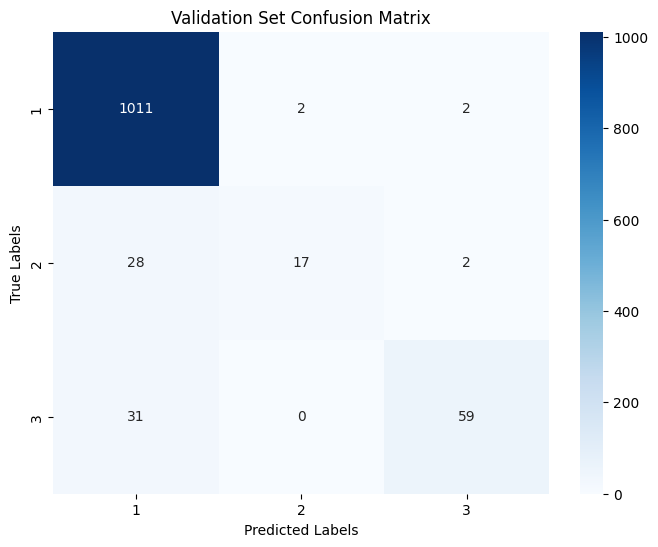

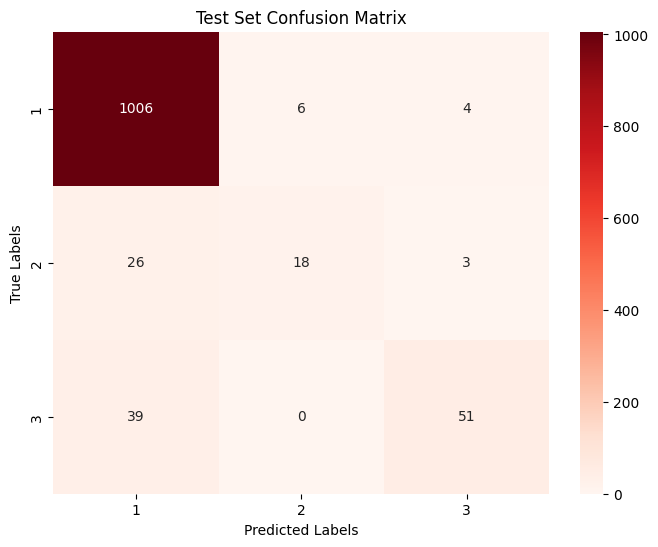

In [12]:
# Step 9: Print classification report and confusion matrix for validation and test
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Function to plot a confusion matrix
def plot_confusion_matrix(conf_matrix, title, target_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the validation set confusion matrix
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred), "Validation Set Confusion Matrix", target_names)

# Function to plot a confusion matrix
def plot_confusion_matrix(conf_matrix, title, target_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the test set confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), "Test Set Confusion Matrix", target_names)

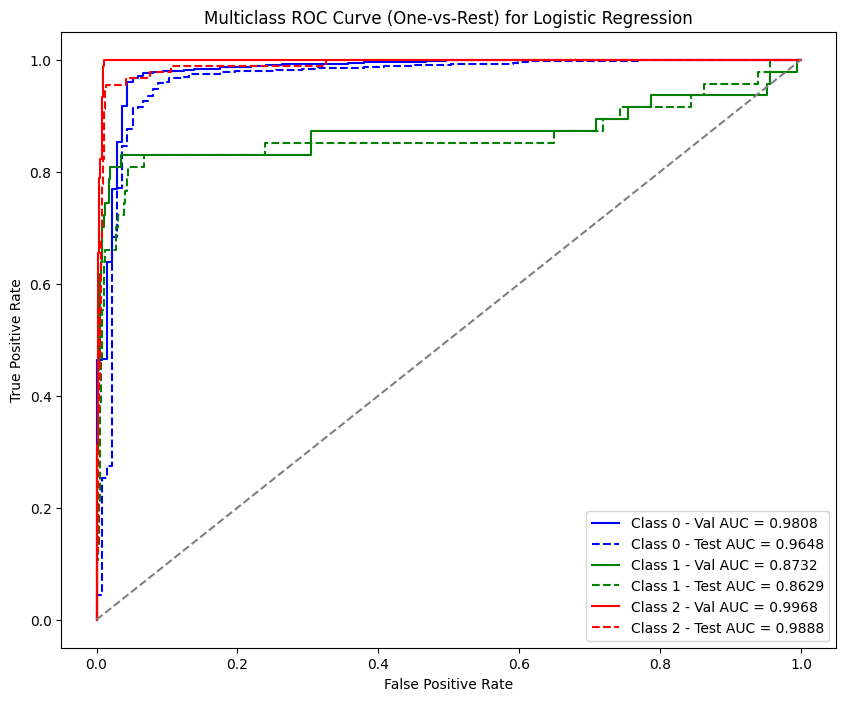

In [13]:
# Step 10: Plot the ROC curve for multiclass classification (One-vs-Rest)
# Binarize the target labels for ROC curve calculation
y_val_bin = label_binarize(y_val, classes=y.unique())  # Adjust classes based on your dataset
y_test_bin = label_binarize(y_test, classes=y.unique())

# Get the predicted probabilities for each class
y_val_pred_prob = model.predict_proba(X_val)
y_test_pred_prob = model.predict_proba(X_test)

# Initialize plot
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each class
n_classes = y_val_bin.shape[1]
colors = ['b', 'g', 'r']  # Use colors for different classes

for i in range(n_classes):
    # ROC curve for the current class
    fpr_val, tpr_val, _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])

    # AUC for the current class
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve for the validation set
    plt.plot(fpr_val, tpr_val, color=colors[i], label=f'Class {i} - Val AUC = {roc_auc_val:.4f}')
    # Plot ROC curve for the test set
    plt.plot(fpr_test, tpr_test, color=colors[i], linestyle='--', label=f'Class {i} - Test AUC = {roc_auc_test:.4f}')

# Plot the diagonal line (no skill classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest) for Logistic Regression')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Comparison: KNN vs Logistic Regression

Both KNN and Logistic Regression performed well, with KNN achieving slightly higher test accuracy (**95% vs. 93%**). KNN demonstrated better handling of minority classes, with higher F1-scores for Classes 2 and 3, leveraging its distance-based approach to capture localized patterns effectively.

Logistic Regression, on the other hand, excelled in computational simplicity and scalability, making it more efficient and interpretable for larger datasets. However, it struggled with minority classes due to lower recall, highlighting the trade-off between simplicity and performance in handling imbalanced data.
